<a href="https://colab.research.google.com/github/thielis/EstudoAIeCDUFES/blob/main/IA_CD_L03_BERT_BBC_especificacao_Thielis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

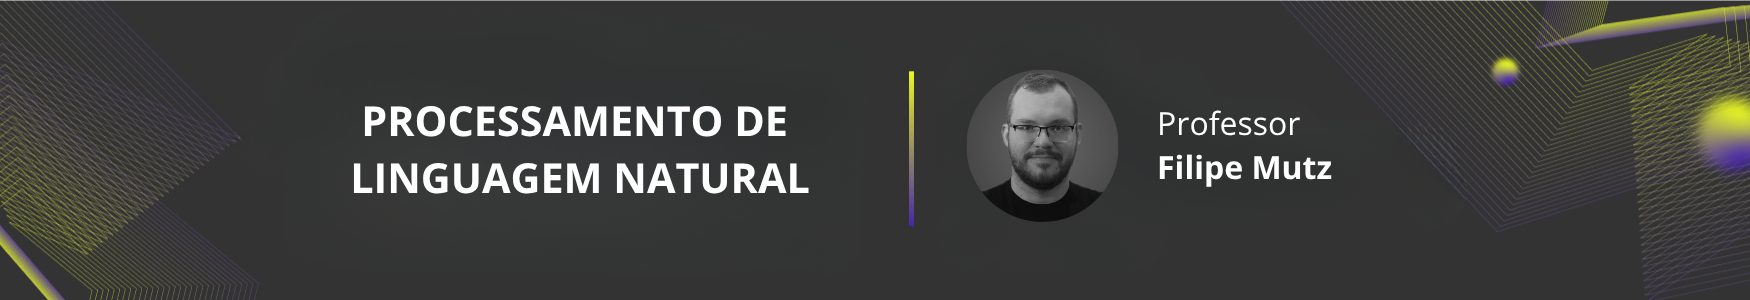

### Aluno: Thielis Barroso Ferreira

# 📝🤖 Classificação de Textos usando BERT *Embeddings*


Este laboratório tem como objetivo praticar a transformação de textos em *embeddings* usando BERT, um LLM pré-treinado baseado no modelo Transformer, e o seu uso para classificação de textos. Será utilizada a base de dados [BBC News Archive](https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive). Para relembrar, ela possui 2225 notícias organizadas nas classes '*business*', '*entertainment*', '*politics*', '*sport*', '*tech*'.


**As atividades que devem ser realizadas estão nos tópicos:**
- Atividade 1: Tokenização
- Atividade 2: Transformação dos Textos Codificados em Embeddings
- Atividade 3: Definição do Classificador

O primeiro item vale 40 pontos e os demais valem 30 pontos.

Depois de completar as atividades, execute todas as células do notebook.

## Preparação do Ambiente e Imports de Bibliotecas

In [ ]:

import os
import re

import torch
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from tqdm.auto import tqdm


# Ativa o tqdm nas operações do pandas
tqdm.pandas()

# configura o estilo dos plots
sns.set_style('darkgrid')


## Download do Dataset

Vamos utilizar a biblioteca *kagglehub* para fazer o download do dataset e a biblioteca pandas para ler o arquivo `.csv` em um *data frame* e embaralhá-lo.

In [ ]:

ds_path = kagglehub.dataset_download("hgultekin/bbcnewsarchive")
csv_path = os.path.join(ds_path, 'bbc-news-data.csv')
df = pd.read_csv(csv_path, sep= '\t')
df = df.sample(frac=1, random_state=42)
df

Using Colab cache for faster access to the 'bbcnewsarchive' dataset.


,category,filename,title,content
414,business,415.txt,UK house prices dip in November,"UK house prices dipped slightly in November, ..."
420,business,421.txt,LSE 'sets date for takeover deal',The London Stock Exchange (LSE) is planning t...
1644,sport,332.txt,Harinordoquy suffers France axe,Number eight Imanol Harinordoquy has been dro...
416,business,417.txt,Barclays shares up on merger talk,Shares in UK banking group Barclays have rise...
1232,politics,337.txt,Campaign 'cold calls' questioned,Labour and the Conservatives are still teleph...
...,...,...,...,...
1638,sport,326.txt,Robinson answers critics,England captain Jason Robinson has rubbished ...
1095,politics,200.txt,Mallon wades into NE vote battle,Middlesbrough mayor Ray Mallon has been draft...
1130,politics,235.txt,Lib Dems' new election PR chief,The Lib Dems have appointed a senior figure f...
1294,politics,399.txt,Tories reject rethink on axed MP,Sacked MP Howard Flight's local Conservative ...


## Atividade 1: Tokenização

Na célula abaixo, carregue o tokenizer do modelo `bert-base-uncased` usando a classe `BertTokenizer`.

In [ ]:
from transformers import BertTokenizer

# tokenizer = ... # #### ADICIONE SUA RESPOSTA AQUI ####
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

Use uma frase como entrada para o tokenizer e visualize sua saída. Lembre-se que como o tokernizer implementa o método `__call__`, ele pode ser usado como uma função:

```python
>> tokenizer('hello world')
{'input_ids': [101, 7592, 2088, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}
```

O número de tokens na chave `input_ids` é maior que o número de palavras porque o tokenizador do BERT faz divisão em subpalavras.


In [ ]:
# #### ADICIONE SUA RESPOSTA AQUI ####
tokenizer('hello world')

{'input_ids': [101, 7592, 2088, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

Aplique o tokenizador a todos os textos da base de dados. Utilize o tamanho máximo da sequência de `200` e defina que o tokenizador deve realizar `padding` para este valor. Não é necessário realizar outros pré-processamentos nesta base e os textos podem ser usados diretamente como entrada para o tokenizador.

‼️É esperado que esta operação demore cerca de `20s`.

In [ ]:

MAX_SEQ_LENGTH = 200

def perform_tokenization(text):
  # #### ADICIONE SUA RESPOSTA AQUI ####
  inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=MAX_SEQ_LENGTH)

  return inputs

tokens = df['content'].progress_apply(perform_tokenization)
tokens

  0%|          | 0/2225 [00:00<?, ?it/s]

,content
414,"[input_ids, token_type_ids, attention_mask]"
420,"[input_ids, token_type_ids, attention_mask]"
1644,"[input_ids, token_type_ids, attention_mask]"
416,"[input_ids, token_type_ids, attention_mask]"
1232,"[input_ids, token_type_ids, attention_mask]"
...,...
1638,"[input_ids, token_type_ids, attention_mask]"
1095,"[input_ids, token_type_ids, attention_mask]"
1130,"[input_ids, token_type_ids, attention_mask]"
1294,"[input_ids, token_type_ids, attention_mask]"


## Atividade 2: Transformação dos Textos Codificados em *Embeddings*

Carregue o modelo `bert-base-uncased` usando a classe `BertModel`. Este modelo será utilizado para transformar textos em *embeddings*.

In [ ]:
from transformers import BertModel

# model = ... # #### ADICIONE SUA RESPOSTA AQUI ####
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()
model

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

A célula abaixo usa o BERT para extrair os embeddings representando os textos.

In [ ]:
# verifica se existe uma GPU disponível e
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# tamanho do batch
batch_size = 2

# move o modelo para a GPU, se possível.
model.to(device)
model.eval()

def get_embedding(inputs):
  # move os tokens para a GPU
  inputs = {key: val.to(device) for key, val in inputs.items()}

  # passa os tokens pelo o BERT
  outputs = model(**inputs)

  # seleciona a saída pooler_outputs contendo o
  # a representação vetorial (embedding) do texto.
  embedding = outputs.pooler_output

  # move o embedding para a CPU e o retorna
  return embedding.to('cpu')


with torch.no_grad():
  embeddings = tokens.progress_apply(get_embedding)

embeddings = torch.cat(embeddings.tolist(), dim=0)
embeddings

  0%|          | 0/2225 [00:00<?, ?it/s]

tensor([[-0.7912, -0.7126, -0.9887,  ..., -0.9161, -0.7546,  0.5679],
        [-0.8255, -0.6505, -0.9851,  ..., -0.9385, -0.6492,  0.6089],
        [-0.2182, -0.3998, -0.9906,  ..., -0.9805, -0.1845, -0.2669],
        ...,
        [-0.8637, -0.6348, -0.9808,  ..., -0.9259, -0.7306,  0.6881],
        [-0.3305, -0.5586, -0.9735,  ..., -0.7478, -0.5332,  0.1018],
        [-0.7538, -0.6120, -0.9825,  ..., -0.9287, -0.6671,  0.4665]])

## Preparação dos Conjuntos de Treino e Teste

A célula abaixo transforma os nomes das classes em inteiros.

In [ ]:
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
y = label_enc.fit_transform(df['category'].to_numpy())
y = y.astype(np.int64)
y = torch.tensor(y)
y

tensor([0, 0, 3,  ..., 2, 2, 1])

A célula abaixo divide os dados em conjuntos de treino e teste.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    embeddings, y,
    test_size=0.2,
    random_state=42,
)

train_ds = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

test_ds = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_ds, batch_size=64)


## Atividade 3: Definição do Classificador

Use o método `nn.Sequential` para criar um classificador multilayer perceptron (MLP) que receba como entrada os *embeddings* e classifique em uma das 5 classes. Use pelo menos duas camadas totalmente conectadas com uma função de ativação não-linear entre elas.

In [ ]:
from torch import nn

# classifier = ... # #### ADICIONE SUA RESPOSTA AQUI ####
classifier = nn.Sequential(
    nn.Linear(768, 32),
    nn.Tanh(),
    nn.Dropout(),
    nn.Linear(32, 5),
)

classifier


Sequential(
  (0): Linear(in_features=768, out_features=32, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=32, out_features=5, bias=True)
)

## Treinamento e Avaliação

A célula abaixo faz o treinamento do modelo e mostra os valores da função de perda ao longo das épocas.

In [ ]:
import torch.optim as optim

# função de perda será a entropia cruzada
criterion = nn.CrossEntropyLoss()

# otimizador responsável pela atualização dos parâmetros
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

# histórico de valores da função de perda
history = []

# número de épocas
n_epochs = 40

# repete por um número de épocas
for epoch in range(n_epochs):
    running_loss = 0.0

    # epoca de treinamento: itera sobre os batches do conjunto de treino
    classifier.train()

    # itera sobre os batches
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # zera os gradientes
        optimizer.zero_grad()
        # passa as entradas pelo modelo
        outputs = classifier(inputs)
        # computa a função de perda usando a saída e as anotações
        loss = criterion(outputs, labels)
        # calcula os gradientes
        loss.backward()
        # atualiza os parâmetros usando os gradientes
        optimizer.step()

        running_loss += loss.item()

    running_loss /= len(train_loader)

    # avaliação no conjunto de teste
    classifier.eval()
    test_loss = 0.0

    # informa ao pytorch que não é necessário computar gradientes para
    # estas operações
    with torch.no_grad():
        # itera sobre os batches de teste
        for data in test_loader:
            inputs, labels = data
            # passa os vetores pelo classificador
            outputs = classifier(inputs)
            # calcula a função de perda
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_loss /= len(test_loader)

    history.append([running_loss, test_loss])

    # exibe o valor da perda 20x
    if epoch % max(1, n_epochs // 20)  == 0:
        print(f'[{epoch + 1}] loss: {running_loss:.4f} test loss: {test_loss:.4f}')

print('Finished Training')

[1] loss: 1.5622 test loss: 1.4211
[3] loss: 1.1566 test loss: 1.0268
[5] loss: 0.8710 test loss: 0.7832
[7] loss: 0.6709 test loss: 0.5893
[9] loss: 0.5325 test loss: 0.4872
[11] loss: 0.4662 test loss: 0.3536
[13] loss: 0.4030 test loss: 0.2979
[15] loss: 0.3677 test loss: 0.2870
[17] loss: 0.3177 test loss: 0.2404
[19] loss: 0.2886 test loss: 0.2431
[21] loss: 0.2826 test loss: 0.2142
[23] loss: 0.2960 test loss: 0.2225
[25] loss: 0.2703 test loss: 0.1979
[27] loss: 0.2354 test loss: 0.2022
[29] loss: 0.2465 test loss: 0.1827
[31] loss: 0.2313 test loss: 0.1599
[33] loss: 0.2163 test loss: 0.1590
[35] loss: 0.2239 test loss: 0.1584
[37] loss: 0.2271 test loss: 0.1663
[39] loss: 0.1949 test loss: 0.1594
Finished Training


O gráfico a seguir mostra a evolução dos valores da função de perda para os conjuntos de treino e teste.

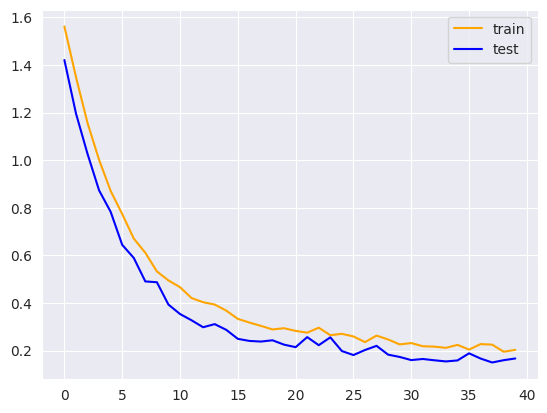

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

history = np.array(history)

plt.plot(history[:, 0], '-', color='orange', label='train')
plt.plot(history[:, 1], '-', color='blue', label='test')
plt.legend()

A célula a seguir computa métricas para conjunto de teste ao final do treinamento. É esperado que o modelo alcance mais de 90% de acurácia.

In [ ]:
from sklearn.metrics import classification_report

all_labels = []
preds = []

classifier.eval()
with torch.no_grad():
    # itera sobre os batches de teste
    for data in test_loader:
        inputs, labels = data
        # passa os vetores pelo classificador
        outputs = classifier(inputs)
        # identifica as classes com maior probabilidade
        cls = np.argmax(outputs, axis=-1)
        # salva as classes verdadeiras e preditas em listas
        all_labels += list(labels)
        preds += list(cls)

# mostra o relatório de classificação
print(classification_report(all_labels, preds))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       102
           1       0.88      0.97      0.92        72
           2       0.93      0.96      0.95        72
           3       1.00      0.99      1.00       110
           4       0.92      0.90      0.91        89

    accuracy                           0.94       445
   macro avg       0.94      0.94      0.94       445
weighted avg       0.95      0.94      0.94       445



A célula abaixo faz uma análise qualitativa do modelo usando algumas frases de exemplo.

In [ ]:

# instancia uma operação de softmax
softmax = torch.nn.Softmax(dim=-1)

# coloca o classificador em modo de avaliação
classifier.eval()

def avalia_sentenca(text):
  # informa ao pytorch que as próximas operações não demandam gradientes
  with torch.no_grad():
    # passa o texto pelo tokenizador
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    # move as informações para a gpu
    inputs = {key: val.to(device) for key, val in inputs.items()}
    # passa os tokens pelo BERT e acessa o embedding da sentença
    embedding = model(**inputs).pooler_output
    # move o embedding para a cpu
    embedding = embedding.to('cpu')
    # passa o vetor pelo classificador
    logits = classifier(embedding)
    # transforma os logits em probabilidades
    probs = softmax(logits)
    probs = np.squeeze(probs)
    # seleciona a classe com maior probabilidade
    cls = np.argmax(probs)
    # mostra na tela a frase, as psobabilidades e classe selecionada
    print(f"Frase: {text}")
    print(f"\nProbs: {probs}")
    print(f"Class: {label_enc.classes_[cls]}\n")
    print("------------\n")


# avalia o classificador com algumas frases de exemplo

# sport
avalia_sentenca("Liverpool have signed 18-year-old defender Giovanni Leoni from Italian side Parma for a fee of £26m plus add-ons. Leoni, who Reds boss Arne Slot confirmed the club had agreed a deal for earlier this week, has signed a contract until 2031. The Italy Under-19s centre-back began his career at Padova and had a short spell at Sampdoria before joining Parma last summer. Leoni played 17 games in his first campaign in Serie A last season, attracting interest from both Milan clubs, but has opted for a move abroad.")

# business
avalia_sentenca("Shares in Intel jumped by more than 7% on Thursday, following reports that the Trump administration is in talks to take a stake in the chipmaker. The reported deal would support the technology firm's plans to build a manufacturing hub in Ohio, according to Bloomberg, which said the size of the potential stake is not clear. White House spokesman Kush Desai said 'discussion about hypothetical deals should be regarded as speculation unless officially announced by the administration'.")

# tech
avalia_sentenca("Apple on Tuesday released its sixth developer beta of its mobile operating system, iOS 26, along with updates for iPad, Apple Watch, Apple TV, Mac, and others. As the new software gets closer to its September public launch date, the changes and tweaks aren't as significant, but there are still some surprises to be found. In beta 6, that includes a new selection of ringtones, a final decision on the Camera swiping direction controversy, a new onboarding experience, and other updates. There was quite a bit of backlash over the way Apple changed how the Camera mode switcher responds to touch. Users complained that the change, introduced in prior betas, broke their muscle memory, since the swipe gesture on this interface would reverse the scroll direction they were used to — which was the same design paradigm that all other native Apple apps use. In beta 5, Apple responded to these complaints by introducing a new Settings toggle that would allow you to switch back to 'Classic Mode', which would once again make the Camera app work like all others.")

# politics
avalia_sentenca("Watching the president of France and the prime minister close up was to see two men under the cosh, behind in the opinion polls and fighting for what they see as the essence of their political creed. It boils down to this - how do Sir Keir Starmer and Emmanuel Macron make the case for what they see as the virtues of patience, nuance, subtleties and trade-offs in an era of growing impatience at the perceived repeated failures of those in high office? There were just two lecterns and two speakers at the news conference the leaders hosted, but two other parties hovered in the air. Reform UK and National Rally, the party of Jordan Bardella and Marine Le Pen, were never mentioned explicitly. Nor were their leaders. But they were repeatedly mentioned implicitly.")


Frase: Liverpool have signed 18-year-old defender Giovanni Leoni from Italian side Parma for a fee of £26m plus add-ons. Leoni, who Reds boss Arne Slot confirmed the club had agreed a deal for earlier this week, has signed a contract until 2031. The Italy Under-19s centre-back began his career at Padova and had a short spell at Sampdoria before joining Parma last summer. Leoni played 17 games in his first campaign in Serie A last season, attracting interest from both Milan clubs, but has opted for a move abroad.

Probs: tensor([2.6897e-04, 7.3902e-04, 7.3531e-05, 9.9890e-01, 1.5999e-05])
Class: sport

------------

Frase: Shares in Intel jumped by more than 7% on Thursday, following reports that the Trump administration is in talks to take a stake in the chipmaker. The reported deal would support the technology firm's plans to build a manufacturing hub in Ohio, according to Bloomberg, which said the size of the potential stake is not clear. White House spokesman Kush Desai said 'discus

É esperado que o modelo realize as classificações corretamente.